In [1]:
from sncosmo.utils import Result, Interp1D,ppf
import scipy
import numpy as np
import matplotlib.pyplot as plt

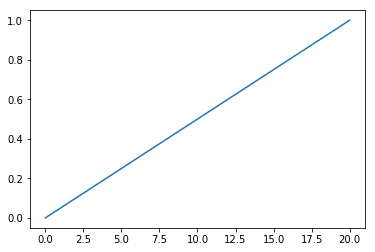

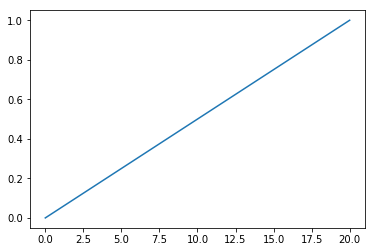

In [2]:
bounds={'v':(0,100),'g':(0,20)}
a,b=bounds['g']
x_samples = np.linspace(0., 1., 101)
#ppf_samples = ppf(bounds['g'], x_samples, a, b)
f = Interp1D(0., 1., np.array([a, b]))
f2=scipy.interpolate.interp1d([0.,1.],bounds['g'])
#plt.plot(x_samples[:-1],[f(x) for x in x_samples[:-1]])
data=np.array([f2(x) for x in x_samples])
plt.plot(data,x_samples)
plt.show()
data2=bounds['g']
p = 1. * np.arange(len(data2)) / (len(data2) - 1)
plt.plot(data2,p)
plt.show()

In [3]:
def prior_transform(u):
        d = {}
        for i in range(npdim):
            d[iparam_names[i]] = ppflist[i](u[i])
        v = np.empty(ndim, dtype=np.float)
        for i in range(ndim):
            key = vparam_names[i]
            v[i] = d[key]
        return v

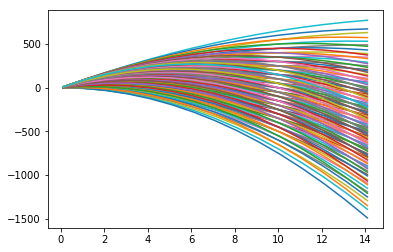

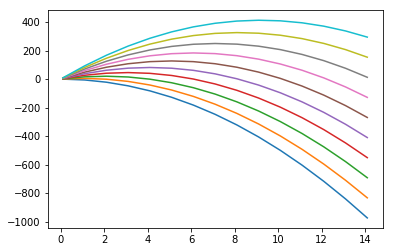

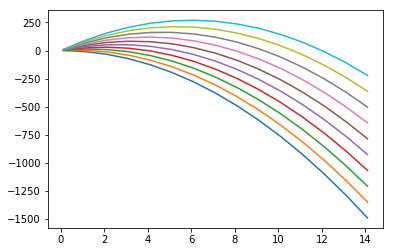

In [4]:
v1 = 50.
g1 = 9.8

def my_model( v,g, t):
    return v*t -.5*g*t**2
ts=np.arange(0.1,15,1)
for v in np.arange(0,100,10):
    for g in np.arange(5,15.3):
        plt.plot(ts,my_model(v,g,ts))
plt.show()

for v in np.arange(0,100,10):
    plt.plot(ts,my_model(v,9.8,ts))
plt.show()
for v in np.arange(0,100,10):
    plt.plot(ts,my_model(v,15,ts))
plt.show()

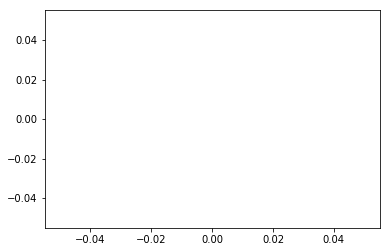

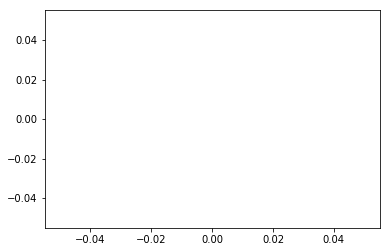

In [5]:
v_tries = []
g_tries = []
chi_tries=[]
def callback(x):
    v_tries.append(x[0])
    g_tries.append(x[1])
    chi_tries.append(chisquare(x,my_args))
    

plt.plot(v_tries,chi_tries)
plt.show()
plt.plot(g_tries,chi_tries)
plt.show()

In [6]:
import numpy as np
import emcee

In [48]:
np.random.seed(120)
# Choose the "true" parameters.
a_true=.4
b_true=1.3
c_true=6

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 1+5*np.random.rand(N)
y = a_true*x**2+b_true*x+c_true#+b_true
#y += np.abs(f_true*y) * np.random.randn(N)
y += (yerr * 2*np.random.randn(N))

In [49]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
a_ls,b_ls, c_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print(a_ls,b_ls, c_ls)
plt.errorbar(x,y,yerr=yerr,fmt='.')
plt.plot(x,a_true*x**2+b_true*x+c_true)
plt.plot(x,a_ls*x**2+b_ls*x+c_ls,'r--')
plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

0.38938226245522467 1.3094250480185827 5.975428361472286


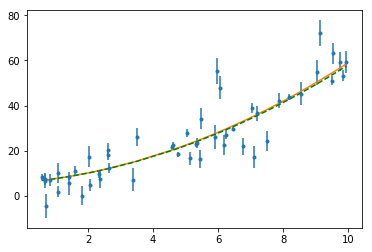

In [51]:
b_tries = []
m_tries = []
chi_tries=[]
def callback(x):
    v_tries.append(x[0])
    g_tries.append(x[1])
    chi_tries.append(chisquare(x,my_args))
    
def lnlike(theta, args):
    x, y, yerr=args
    a,b,c = theta
    model = a*x**2+b*x+c
    inv_sigma2 = 1./yerr**2
    return 0.5*(np.sum((y-model)**2*inv_sigma2 ))

import scipy.optimize as op
result = op.minimize(lnlike, [0,0,0], args=[x, y, yerr])
a_ml, b_ml,c_ml = result["x"]
plt.errorbar(x,y,yerr=yerr,fmt='.')
plt.plot(x,a_true*x**2+b_true*x+c_true)
plt.plot(x,a_ml*x**2+b_ml*x+c_ml,'g--')
print(a_ml, b_ml,c_ml)

In [55]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp - lnlike(theta, [x, y, yerr])

def lnprior(theta):
    a, b,c = theta
    if 0 < a < 5. and 0 < b < 5 and 0 < c < 10:
        return 0.0
    return -np.inf

ndim, nwalkers = 3, 1000
pos = [result["x"] + .1*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 1000)
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))


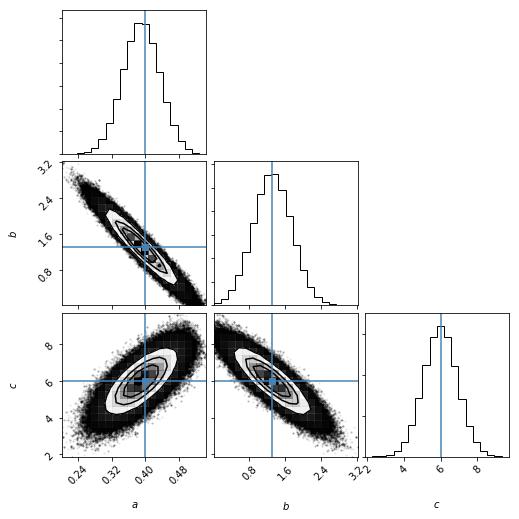

In [56]:
import corner
import matplotlib.pyplot as plt
fig = corner.corner(samples, labels=["$a$", "$b$","$c$"],
                      truths=[a_true, b_true,c_true])
plt.show()

<ErrorbarContainer object of 3 artists>

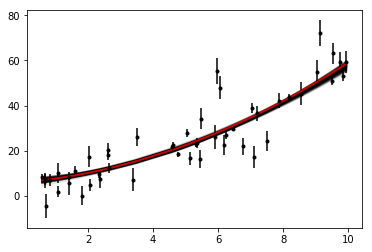

In [57]:
import matplotlib.pyplot as pl
#xl = np.array([0, 10])
for a,b, c in samples[np.random.randint(len(samples), size=150)]:
    pl.plot(x, a*x**2+b*x+c, color="k", alpha=0.1)
pl.plot(x, a_true*x**2+b_true*x+c_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")

In [69]:
#samples[:, 1] = np.exp(samples[:, 1])

a_mcmc, b_mcmc,c_mcmc = np.percentile(samples, 50,axis=0)
print('MCMC:','a=',a_mcmc,'b=',b_mcmc,'c=',c_mcmc)
print('True:','a=',a_true,'b=', b_true,'c=',c_true)

MCMC: a= 0.38996071830453716 b= 1.3027900083883481 c= 5.98338047350309
True: a= 0.4 b= 1.3 c= 6
